# Map Columbia animal complaint calls by city ward

**Problem**: We're working on a rolling investigation and we want to map animal-related 911 calls over a specific time in Columbia, MO, by city ward, but the CSV and KML files available from [the city's open data feed](https://www.como.gov/data-feeds/) are just the "latest" batch -- you can't specify a date range.

**Solution**: Mock a request for calls within that specific date range to get a CSV, then manipulate the data with Python GIS tools.

This project will be a little more involved, requiring a variety of tools to overcome different problems.

We will:
- Download a GIS file of Columbia wards and convert it to a shapefile
- Mock a server request to download a CSV of police calls in Columbia
- Filter the data to include only 'ANIMAL BITE' and 'ANIMAL COMPLAINT' calls
- Manipulate the data so it can be mapped
- Map those points on top of a base map of city wards
- Get a count of animal calls by city ward

... then we'll talk about where we could go from there.

Tools we will be using:
- Python's built-in [`datetime`](https://docs.python.org/3/library/datetime.html) module for working with date values
- A command-line tool called [`ogr2ogr`](http://www.gdal.org/ogr2ogr.html) to convert the city wards file to a shapefile
- `requests`, for fetching the data from the Internet
- `pandas`, for prepping and filtering the call data
- `shapely` and `geopandas`, which will help us turn the data into something we can map

A few reference links to maybe leave open in new tabs:
- [shapely documentation](http://toblerity.org/shapely/)
- [geopandas documentation](http://geopandas.org/)
- [Roberto Rocha's excellent NICAR 2017 notebook on Python GIS tools](https://github.com/robroc/GIS-with-python/blob/master/GIS%20with%20Python.ipynb)

In [1]:
from datetime import date

import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

### Let's download and prepare some GIS data

We want to get a copy of the city's ward boundaries, which is available as a KMZ file [here](http://www.gocolumbiamo.com/Maps/kml/Wards.kmz). A KMZ file is an archival file format ([developed by Google](https://developers.google.com/kml/documentation/kmzarchives)) that can be unzipped to get at the underlying KML file, which contains the map data.

The Python tools we're going to use don't read KML files, however, so first we'll need to convert it. We can convert it to a shapefile ([developed by ESRI](https://en.wikipedia.org/wiki/Shapefile)) using a command-line tool called [`ogr2ogr`](http://www.gdal.org/ogr2ogr.html). You could also open the KML file in your GIS software of choice and convert it.

I downloaded the KMZ file into the `../data` directory. Then I unzipped it, which revealed a KML file called `doc.kml`. Then I ran this command from my computer's Terminal: `ogr2ogr -f 'ESRI Shapefile' columbia-wards.shp doc.kml`

Now we have a shapefile called `columbia_wards.shp` in the `../data` folder.

### Let's download a CSV

We're going to define a function, `get_new_data`, that we can call to get a new CSV of data. This function accepts three keyword arguments:
- `START_DATE`: A Python date object specifying the first date of the call data we want
- `END_DATE`: A Python date object specifying the last date of the call data we want
- `filename`: The path where we want to download the CSV

👉Read more about functions in [this notebook](../reference/Functions.ipynb).

Let's step back and talk about how this function was developed: stepwise, by observing what happens behind the scenes when a user selects a custom date range [on the city's searchable call database](https://www.como.gov/CMS/911dispatch/police.php), clicks "Filter," then clicks "Export CSV."

With some databases, the URL changes depending on the data being requested. That's the case with the police call search function.

The URL of the search page is: `https://www.como.gov/CMS/911dispatch/police.php`

When you search for police calls between 4/11/2018 and 4/18/2018, the URL of the results page is:

`https://www.como.gov/CMS/911dispatch/police.php?type=&keyword=&Start_Date=4%2F11%2F2018&End_Date=4%2F18%2F2018&Submit=Filter`

The base URL is the same. Everything after the `?` is the URL's [_query string_](https://en.wikipedia.org/wiki/Query_string). Each _parameter_ is separated by `&`; the parameters we care about are `Start_Date` and `End_Date`. For each parameter, the value that comes after the `=` sign is what's getting passed along to the city's database. (The slashes in the date are being [encoded](https://en.wikipedia.org/wiki/Percent-encoding) as _%2F_.) 

Could you get to this page without going through the search process? Let's test it out -- open another browser window in incognito mode, or a different browser altogether (I like to swap between Chrome and Firefox) and see if plugging in the results URL works. Spoiler, it does. (Note, too, that it works even if we don't percent-encode the slashes in the dates.)

OK, so half our problem is solved. We can get a page of results by manipulating the URL parameters. What happens when we click the "Export CSV" button? We can watch the network traffic using the browser's developer tools.

On Chrome, show your developer tools by going to View -> Developer -> Developer Tools. A pane should pop up in your browser. Click the "Network" tab and make sure that "All' is selected. From this view, you can watch what happens behind the scenes when your browser makes a request to a server.

![network tab](../img/network.png 'network tab')

Now click the "Export CSV" button and watch what happens. Every request your browser makes to the city's server will show up in that table. We're interested in the request to `police_csvexport.php`.

![export request](../img/network2.png 'export request')

Check out the headers: The request URL is `https://www.como.gov/CMS/911dispatch/police_csvexport.php`, with no URL parameters.

![export request headers](../img/network3.png 'export request headers')

It would be reasonable to assume that the export function works the same way as the search function -- that you can pass URL parameters to specify, e.g., the date range. Spoiler, it does not. Open a fresh browser, or a new window in incognito mode, and try `https://www.como.gov/CMS/911dispatch/police_csvexport.php?Start_Date=4/11/2018&End_Date=4/18/2018`. It will download a file -- but it'll just be the latest CSV, the same one served up on the city's open data feed.

So how does the database export function know which dates to export? Let's look at the request _headers_ -- the bits of information included with the browser's request to the server. Educated guess, but I bet it's using the `referer` URL from the search page, which _does_ have the date parameters -- you'll find the `referer` parameter in the request headers if you scroll down. The headers also include [cookies](https://en.wikipedia.org/wiki/HTTP_cookie), which can be used to keep track of a user's browser state. This suggests that the request to the `police_csvexport.php` URL won't work unless it includes these cookies.

![export request headers](../img/network4.png 'export request headers')

We're using the popular `requests` library to fetch the data, and it has a feature called a [Session object](http://docs.python-requests.org/en/master/user/advanced/#session-objects) that allows you to persist parameters across different requests. The example in the documentation is exactly the thing we're trying to do: Persist a cookie over multiple requests. In other words, we can make a request to the search page, establishing a session (with cookies and the whole bit), and then hit the export URL using the same session -- essentially doing the same thing as browsing to the search page and clicking the export button. But we're doing it programatically.

Which brings us to a good point: Why not just _use_ the browser to download this file? You could, and probably should, if you're only going to do it once or twice. My rule of thumb is, if I need to do a computer task more than twice, I'm going to try to automate it.

In [2]:
def get_new_data(START_DATE=date(2018, 4, 11), END_DATE=date(2018, 4, 18), filename='../data/cops.csv'):
    '''Download a CSV of police calls in Columbia, MO, for a given date range'''

    # get string of first date of police calls you want to grab
    start = START_DATE.strftime("%d/%m/%y")
    
    # get string of end date of police calls you want to grab
    end = END_DATE.strftime("%d/%m/%y")
    
    # set up the URL pattern you'd use to search for that date range
    URL_PATTERN = 'https://www.como.gov/CMS/911dispatch/police.php?' \
                  'Start_Date={}&End_Date={}&Submit=Filter'

    # build the URL
    url = URL_PATTERN.format(start, end)

    # create a session object
    # http://docs.python-requests.org/en/master/user/advanced/#session-objects
    s = requests.Session()

    # fetch the search URL
    s.get(url)

    # using that session, visit the CSV export URL
    r = s.get('https://www.como.gov/CMS/911dispatch/police_csvexport.php')    

    # write the results to file
    with open(filename, 'wb') as f:
        for block in r.iter_content(1024):
            f.write(block)
    
    return filename

In [3]:
# uncomment the next line and run this cell to get the data
get_new_data()

'../data/cops.csv'

In [7]:
# read the police calls into a dataframe
calls = pd.read_csv('../data/cops.csv')

In [8]:
calls.head()

,InNum,CallDateTime,Address,AptLot,geox,geoy,ExtNatureDisplayName,Report,PolArea,DOW,Hour
0,2018076643,4/18/2018 11:58:55 PM,4004 SNOWY OWL DR,,1687744.63,1149949.75,PARKING VIOLATION,NaN,10E,Wednesday,23
1,2018076639,4/18/2018 11:51:45 PM,1817 JUNIPER CIR,,1693932.00,1119251.13,MISSING PERSON,NaN,60E,Wednesday,23
2,2018076634,4/18/2018 11:46:08 PM,1607-G3 SYLVAN LN,,1696866.13,1141543.13,PEACE DISTURBANCE,NaN,40W,Wednesday,23
3,2018076633,4/18/2018 11:45:41 PM,WHITE RIVER DR/PANORAMA LN,,1687676.63,1154738.13,PARKING VIOLATION,NaN,10E,Wednesday,23
4,2018076630,4/18/2018 11:43:13 PM,N COLLEGE AVE/E WALNUT ST,,1691102.13,1135702.88,TRAFFIC STOP,NaN,70,Wednesday,23


In [12]:
# make sure the datetime values are being interpreted as datetimes, not strings
calls['CallDateTime'] = pd.to_datetime(calls['CallDateTime'], format='%m/%d/%Y %I:%M:%S %p')

In [13]:
# using lat/lng values, create a geometry column of shapely Points
calls['geometry'] = calls.apply(lambda row: Point(row.geox, row.geoy), axis=1)

In [14]:
# remove the calls without coordinates
non_null_calls = calls[(pd.notnull(calls.geox) & pd.notnull(calls.geoy))]

In [15]:
# filter for animal calls
animal_calls = non_null_calls[non_null_calls['ExtNatureDisplayName'].isin(['ANIMAL COMPLAINT', 'ANIMAL BITE'])]

In [16]:
animal_calls.head()

,InNum,CallDateTime,Address,AptLot,geox,geoy,ExtNatureDisplayName,Report,PolArea,DOW,Hour,geometry
88,2018076353,2018-04-18 16:53:17,JORDAN CT/BRIGHT STAR DR,,1668721.25,1136881.88,ANIMAL COMPLAINT,NaN,50W,Wednesday,16,POINT (1668721.25 1136881.88)
307,2018075592,2018-04-17 17:23:51,2200-BLK GRINDSTONE PKWY,,1695474.25,1121459.00,ANIMAL COMPLAINT,NaN,80S,Tuesday,17,POINT (1695474.25 1121459)
469,2018074979,2018-04-16 20:51:37,MEXICO GRAVEL RD/BALLENGER LN,,1707249.75,1147653.25,ANIMAL COMPLAINT,NaN,40E,Monday,20,POINT (1707249.75 1147653.25)
679,2018074196,2018-04-15 16:27:31,1010 COWAN DR,,1679828.25,1132343.25,ANIMAL COMPLAINT,NaN,50E,Sunday,16,POINT (1679828.25 1132343.25)
860,2018073656,2018-04-14 18:50:32,FORUM BLVD/CHAPEL HILL RD,,1679410.50,1127603.00,ANIMAL COMPLAINT,NaN,50W,Saturday,18,POINT (1679410.5 1127603)


In [17]:
# create a geodataframe from these calls, specifying the correct CRS
# https://epsg.io/102697
gdf = gpd.GeoDataFrame(animal_calls, crs={'init': 'ESRI:102697'})

# ... and re-project to WGS-84
# http://spatialreference.org/ref/epsg/wgs-84/
gdf = gdf.to_crs({'init': 'epsg:4326'})

In [18]:
gdf.head()

,InNum,CallDateTime,Address,AptLot,geox,geoy,ExtNatureDisplayName,Report,PolArea,DOW,Hour,geometry
88,2018076353,2018-04-18 16:53:17,JORDAN CT/BRIGHT STAR DR,,1668721.25,1136881.88,ANIMAL COMPLAINT,NaN,50W,Wednesday,16,POINT (-92.40046380968904 38.95574089574571)
307,2018075592,2018-04-17 17:23:51,2200-BLK GRINDSTONE PKWY,,1695474.25,1121459.00,ANIMAL COMPLAINT,NaN,80S,Tuesday,17,POINT (-92.30649942026197 38.91327510001258)
469,2018074979,2018-04-16 20:51:37,MEXICO GRAVEL RD/BALLENGER LN,,1707249.75,1147653.25,ANIMAL COMPLAINT,NaN,40E,Monday,20,POINT (-92.26487708482851 38.98512212337706)
679,2018074196,2018-04-15 16:27:31,1010 COWAN DR,,1679828.25,1132343.25,ANIMAL COMPLAINT,NaN,50E,Sunday,16,POINT (-92.36142917603983 38.94323902374224)
860,2018073656,2018-04-14 18:50:32,FORUM BLVD/CHAPEL HILL RD,,1679410.50,1127603.00,ANIMAL COMPLAINT,NaN,50W,Saturday,18,POINT (-92.36292303722863 38.93022510084229)


In [23]:
# read in a shapefile of city wards
city_wards = gpd.read_file('../data/columbia-wards.shp')

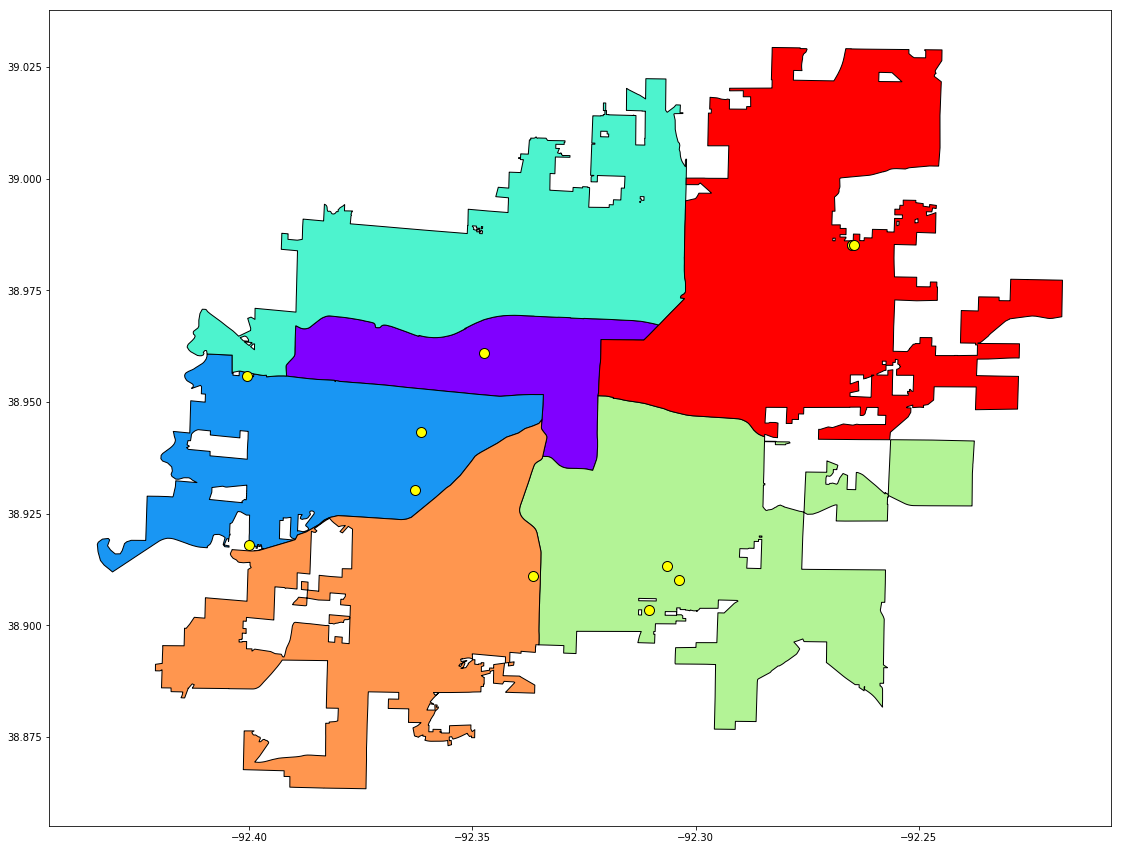

In [48]:
# plot basemap (city wards)
base = city_wards.plot(cmap='rainbow', edgecolor='black', figsize=(30,15))

# plot calls
gdf.plot(ax=base, marker='o', color='yellow', edgecolor='black', markersize=100)

In [33]:
city_wards.Name

index_right
0     Clyde Ruffin
1       Ian Thomas
2    Michael Trapp
3     Betsy Peters
4     Laura Nauser
5       Karl Skala
Name: Name, dtype: object

### How many calls per ward?

In [30]:
per_ward = gpd.tools.sjoin(gdf, city_wards, how='left', op='within')
per_ward.head()

,InNum,CallDateTime,Address,AptLot,geox,geoy,ExtNatureDisplayName,Report,PolArea,DOW,Hour,geometry,index_right,Name,Descriptio
88,2018076353,2018-04-18 16:53:17,JORDAN CT/BRIGHT STAR DR,,1668721.25,1136881.88,ANIMAL COMPLAINT,NaN,50W,Wednesday,16,POINT (-92.40046380968904 38.95574089574571),1.0,Ian Thomas,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For..."
307,2018075592,2018-04-17 17:23:51,2200-BLK GRINDSTONE PKWY,,1695474.25,1121459.00,ANIMAL COMPLAINT,NaN,80S,Tuesday,17,POINT (-92.30649942026197 38.91327510001258),3.0,Betsy Peters,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For..."
469,2018074979,2018-04-16 20:51:37,MEXICO GRAVEL RD/BALLENGER LN,,1707249.75,1147653.25,ANIMAL COMPLAINT,NaN,40E,Monday,20,POINT (-92.26487708482851 38.98512212337706),5.0,Karl Skala,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For..."
679,2018074196,2018-04-15 16:27:31,1010 COWAN DR,,1679828.25,1132343.25,ANIMAL COMPLAINT,NaN,50E,Sunday,16,POINT (-92.36142917603983 38.94323902374224),1.0,Ian Thomas,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For..."
860,2018073656,2018-04-14 18:50:32,FORUM BLVD/CHAPEL HILL RD,,1679410.50,1127603.00,ANIMAL COMPLAINT,NaN,50W,Saturday,18,POINT (-92.36292303722863 38.93022510084229),1.0,Ian Thomas,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For..."
